In [35]:
import pandas as pd
import geopandas as gpd
from vega import VegaLite
from vega.widget import VegaWidget
import json
import requests
import numpy as np
from matplotlib import pyplot as plt
import altair as alt
from uszipcode import SearchEngine
from vega_datasets import data

In [36]:
search = SearchEngine(db_file_path="./tmp/zipcodes.sqlite") 

In [37]:
df = pd.read_csv("speedcameraviolations.csv")

In [38]:
df_clean = df.dropna()

In [39]:

earliest_dates = df_clean.groupby('CAMERA ID')['VIOLATION DATE'].min().reset_index()
earliest_dates

CAMERA ID VIOLATION DATE
0      CHI003     01/01/2015
1      CHI004     01/01/2015
2      CHI005     01/01/2015
3      CHI007     01/01/2015
4      CHI008     01/01/2015
..        ...            ...
171    CHI199     05/19/2023
172    CHI201     05/02/2023
173    CHI202     03/20/2023
174    CHI203     03/20/2023
175    CHI204     07/28/2023

[176 rows x 2 columns]

In [40]:
#Aggregate by year
type(earliest_dates['VIOLATION DATE'].head(1)[0])
earliest_dates['VIOLATION DATE'] = pd.to_datetime(earliest_dates['VIOLATION DATE'])
earliest_dates['VIOLATION DATE YEAR'] = earliest_dates['VIOLATION DATE'].dt.year
earliest_dates

CAMERA ID VIOLATION DATE  VIOLATION DATE YEAR
0      CHI003     2015-01-01                 2015
1      CHI004     2015-01-01                 2015
2      CHI005     2015-01-01                 2015
3      CHI007     2015-01-01                 2015
4      CHI008     2015-01-01                 2015
..        ...            ...                  ...
171    CHI199     2023-05-19                 2023
172    CHI201     2023-05-02                 2023
173    CHI202     2023-03-20                 2023
174    CHI203     2023-03-20                 2023
175    CHI204     2023-07-28                 2023

[176 rows x 3 columns]

In [41]:
count_by_year = earliest_dates.groupby('VIOLATION DATE YEAR').size().reset_index(name="count")
count_by_year

VIOLATION DATE YEAR  count
0                 2015     70
1                 2016     11
2                 2019      4
3                 2020     52
4                 2022     16
5                 2023     23

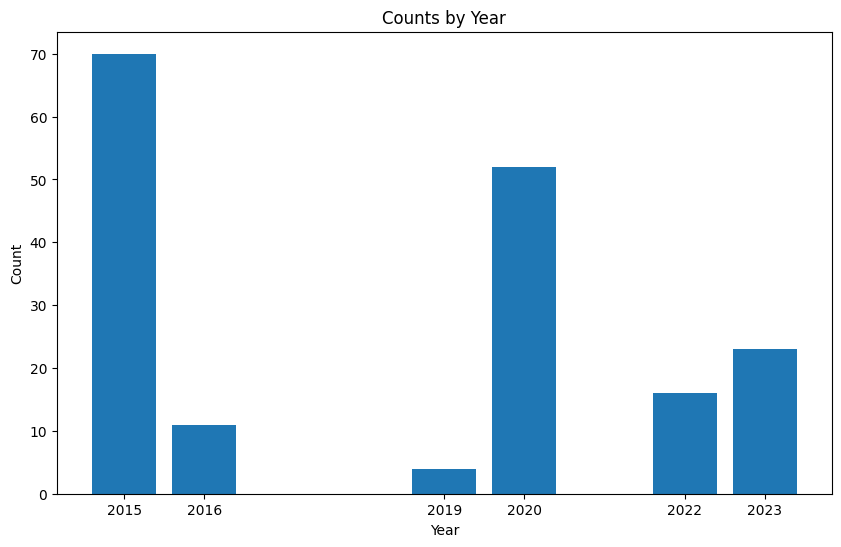

In [42]:

plt.figure(figsize=(10, 6))
plt.bar(count_by_year['VIOLATION DATE YEAR'], count_by_year['count'])
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Counts by Year')
plt.xticks(count_by_year['VIOLATION DATE YEAR'])
plt.show()


In [43]:
#count_by_year.to_json(orient='records', lines = True)
json_string = count_by_year.to_json(orient='records', lines = True).replace("\n",",")
json_string = json_string[:-1]
json_string

'{"VIOLATION DATE YEAR":2015,"count":70},{"VIOLATION DATE YEAR":2016,"count":11},{"VIOLATION DATE YEAR":2019,"count":4},{"VIOLATION DATE YEAR":2020,"count":52},{"VIOLATION DATE YEAR":2022,"count":16},{"VIOLATION DATE YEAR":2023,"count":23}'

In [44]:
#Number of cameras added per year, copy and 
example = {
  "description": "A simple bar chart with embedded data.",
  "data": {
    "values": [
      {"VIOLATION DATE YEAR":2015,"count":70},
      {"VIOLATION DATE YEAR":2016,"count":11},
      {"VIOLATION DATE YEAR":2019,"count":4},
      {"VIOLATION DATE YEAR":2020,"count":52},
      {"VIOLATION DATE YEAR":2022,"count":16},
      {"VIOLATION DATE YEAR":2023,"count":23}
    ]
  },
  "mark": "bar",
  "encoding": {
    "x": {"field": "VIOLATION DATE YEAR", "type": "nominal", "quantitative": {"labelAngle": 0}},
    "y": {"field": "count", "type": "quantitative"}
  }
}

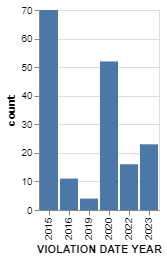

In [45]:
VegaLite(example)

In [46]:
count_by_year

VIOLATION DATE YEAR  count
0                 2015     70
1                 2016     11
2                 2019      4
3                 2020     52
4                 2022     16
5                 2023     23

In [47]:
#lets try this in altair
chart = alt.Chart(count_by_year)
vegaViz1 = chart.mark_bar().encode(
    alt.X('VIOLATION DATE YEAR', type='nominal'),
    alt.Y('count', type='quantitative')
)
vegaViz1

alt.Chart(...)

In [48]:
vegaViz1.to_json().replace("\n","")

'{  "$schema": "https://vega.github.io/schema/vega-lite/v5.15.1.json",  "config": {    "view": {      "continuousHeight": 300,      "continuousWidth": 300    }  },  "data": {    "name": "data-ada5567b7e277f48fd9e7e6052e7a8cd"  },  "datasets": {    "data-ada5567b7e277f48fd9e7e6052e7a8cd": [      {        "VIOLATION DATE YEAR": 2015,        "count": 70      },      {        "VIOLATION DATE YEAR": 2016,        "count": 11      },      {        "VIOLATION DATE YEAR": 2019,        "count": 4      },      {        "VIOLATION DATE YEAR": 2020,        "count": 52      },      {        "VIOLATION DATE YEAR": 2022,        "count": 16      },      {        "VIOLATION DATE YEAR": 2023,        "count": 23      }    ]  },  "encoding": {    "x": {      "field": "VIOLATION DATE YEAR",      "type": "nominal"    },    "y": {      "field": "count",      "type": "quantitative"    }  },  "mark": {    "type": "bar"  }}'

In [49]:
df_agg_by_date = df_clean[['VIOLATION DATE','VIOLATIONS']].reset_index()
df_agg_by_date = df_agg_by_date.groupby('VIOLATION DATE').sum().reset_index()
#Want to aggregate by month
df_agg_by_date['VIOLATION DATE'] = pd.to_datetime(df_agg_by_date['VIOLATION DATE'])
monthly_violations = df_agg_by_date.groupby(df_agg_by_date['VIOLATION DATE'].dt.to_period('M')).sum().reset_index()

monthly_violations

C:\Users\waleed\AppData\Local\Temp\ipykernel_13236\2690163793.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_violations = df_agg_by_date.groupby(df_agg_by_date['VIOLATION DATE'].dt.to_period('M')).sum().reset_index()


VIOLATION DATE       index  VIOLATIONS
0          2014-07   513178245      122282
1          2014-08   412645460       87668
2          2014-09   624551708      112615
3          2014-10   671071282      105822
4          2014-11   606561814      100381
..             ...         ...         ...
106        2023-05  1370850899      231313
107        2023-06  1024600225      205828
108        2023-07  1125738326      199410
109        2023-08  1104839985      179943
110        2023-09   716243281      101421

[111 rows x 3 columns]

In [50]:
#return datetime back to strings so we can use them in altair
monthly_violations['VIOLATION DATE'] = monthly_violations['VIOLATION DATE'].dt.strftime('%Y-%m')
chart = alt.Chart(monthly_violations)
vegaViz2 = chart.mark_line().encode(
    alt.X('VIOLATION DATE', type='ordinal'),  #date on x
    alt.Y('VIOLATIONS', type='quantitative')  #count on y
)
vegaViz2



alt.Chart(...)

In [51]:
vegaViz2.to_json().replace("\n","")

'{  "$schema": "https://vega.github.io/schema/vega-lite/v5.15.1.json",  "config": {    "view": {      "continuousHeight": 300,      "continuousWidth": 300    }  },  "data": {    "name": "data-cb71b6b960033bc5e5009d80c24679e9"  },  "datasets": {    "data-cb71b6b960033bc5e5009d80c24679e9": [      {        "VIOLATION DATE": "2014-07",        "VIOLATIONS": 122282,        "index": 513178245      },      {        "VIOLATION DATE": "2014-08",        "VIOLATIONS": 87668,        "index": 412645460      },      {        "VIOLATION DATE": "2014-09",        "VIOLATIONS": 112615,        "index": 624551708      },      {        "VIOLATION DATE": "2014-10",        "VIOLATIONS": 105822,        "index": 671071282      },      {        "VIOLATION DATE": "2014-11",        "VIOLATIONS": 100381,        "index": 606561814      },      {        "VIOLATION DATE": "2014-12",        "VIOLATIONS": 102088,        "index": 658267517      },      {        "VIOLATION DATE": "2015-01",        "VIOLATIONS": 79422,    

In [52]:
df_cameras_violations = df_clean['VIOLATIONS'].groupby(df_clean['CAMERA ID'])
#Which Cameras have the highest daily average
cameras_sorted = df_cameras_violations.mean().reset_index(name = 'Daily Average').sort_values(by=['Daily Average'], ascending = False)
#CHI189 CHI193 CHI197 CHI 191 are close in nuumber and also have the highest numbers reporting around 300 violations a day
#Do the numbers being close to each other mean that they are close geographically, is this one area a speed hot spot, or is it just a popular area or  both
#The lowest ones average around only 1 or 2 violations per day, where are these? are these our insight into where the least populated spots in chicago are>
#or are these the best places to drive?
#lets see

#Associate latitude and longitude so we can map it later
cameras_sorted = cameras_sorted.merge(df_clean[['CAMERA ID', 'LATITUDE', 'LONGITUDE']], on = "CAMERA ID").drop_duplicates().reset_index()
cameras_sorted


index CAMERA ID  Daily Average   LATITUDE  LONGITUDE
0         0    CHI189     319.337079  41.899295 -87.631169
1       178    CHI193     295.222222  42.011620 -87.814320
2       259    CHI197     260.573529  41.744224 -87.592943
3       395    CHI191     259.223464  41.967863 -87.752153
4       574    CHI149     203.496691  41.970135 -87.747724
..      ...       ...            ...        ...        ...
174  337397    CHI061       2.708709  41.793080 -87.724957
175  338063    CHI111       2.644955  41.852154 -87.684338
176  338846    CHI098       2.597458  41.801013 -87.686071
177  339790    CHI166       2.347495  41.793392 -87.704348
178  340708    CHI131       1.320225  41.895779 -87.628925

[179 rows x 5 columns]

In [53]:
#want to add zip code column to cameras_sorted

def get_zip_code(latitude, longitude):
    '''This function turns Latitude and Longitude into zipcodes'''
    #print(latitude,longitude)
    try:
        z = search.by_coordinates(lat = latitude,lng =  longitude, radius = 5, returns = 1)
        return z[0].to_dict()['zipcode']
    except:
        z = "error"
        return z
     #access the zipcode from information object


#Add zipcode column to cameras_sorted
cameras_sorted['zip'] = cameras_sorted.apply(lambda camera: get_zip_code(camera['LATITUDE'],camera['LONGITUDE']), axis = 1)
cameras_sorted

index CAMERA ID  Daily Average   LATITUDE  LONGITUDE    zip
0         0    CHI189     319.337079  41.899295 -87.631169  60610
1       178    CHI193     295.222222  42.011620 -87.814320  60714
2       259    CHI197     260.573529  41.744224 -87.592943  60619
3       395    CHI191     259.223464  41.967863 -87.752153  60630
4       574    CHI149     203.496691  41.970135 -87.747724  60630
..      ...       ...            ...        ...        ...    ...
174  337397    CHI061       2.708709  41.793080 -87.724957  60629
175  338063    CHI111       2.644955  41.852154 -87.684338  60608
176  338846    CHI098       2.597458  41.801013 -87.686071  60632
177  339790    CHI166       2.347495  41.793392 -87.704348  60629
178  340708    CHI131       1.320225  41.895779 -87.628925  60601

[179 rows x 6 columns]

In [54]:
averages_by_zip = cameras_sorted.groupby('zip').sum('Daily Average').reset_index()
averages_by_zip = averages_by_zip.sort_values(by='Daily Average', ascending = False)
averages_by_zip.head(10)

zip    index  Daily Average    LATITUDE    LONGITUDE
21  60630   478407     841.493694  293.794383  -614.287594
13  60618   957386     490.511439  335.578304  -701.598276
6   60610    39095     391.837079   83.814636  -175.265195
26  60637   376309     340.453589  208.855143  -438.049127
44  60714      178     295.222222   42.011620   -87.814320
14  60619   494936     293.294194  125.187760  -262.835761
20  60629  2647179     291.302273  501.450647 -1052.595933
23  60632  1714210     270.416909  376.230288  -789.370979
34  60647   402846     233.346130  125.778496  -263.126018
24  60634  2417567     197.733981  377.475639  -790.231001

In [55]:
vegaViz3 = alt.Chart(averages_by_zip.head(10)).mark_arc().encode(
    theta="Daily Average",
    color="zip"
)

vegaViz3
#Top 10 Neighborhoods by summed average daily violations for each camera in the neighborhood

alt.Chart(...)

In [56]:
cameras_sorted


index CAMERA ID  Daily Average   LATITUDE  LONGITUDE    zip
0         0    CHI189     319.337079  41.899295 -87.631169  60610
1       178    CHI193     295.222222  42.011620 -87.814320  60714
2       259    CHI197     260.573529  41.744224 -87.592943  60619
3       395    CHI191     259.223464  41.967863 -87.752153  60630
4       574    CHI149     203.496691  41.970135 -87.747724  60630
..      ...       ...            ...        ...        ...    ...
174  337397    CHI061       2.708709  41.793080 -87.724957  60629
175  338063    CHI111       2.644955  41.852154 -87.684338  60608
176  338846    CHI098       2.597458  41.801013 -87.686071  60632
177  339790    CHI166       2.347495  41.793392 -87.704348  60629
178  340708    CHI131       1.320225  41.895779 -87.628925  60601

[179 rows x 6 columns]

In [57]:
cameras_sorted = cameras_sorted
chart = alt.Chart(cameras_sorted)
vegaViz4 = chart.mark_bar().encode(
    alt.X('CAMERA ID', type='nominal'),
    alt.Y('Daily Average', type='quantitative')
)
vegaViz4
#Daily average of all cameras, distribution

alt.Chart(...)

In [58]:
active_cameras_by_day = df_clean['CAMERA ID'].groupby(df_clean['VIOLATION DATE']).size().reset_index(name = "cameras count" )

In [59]:
active_cameras_by_day['VIOLATION DATE'] = pd.to_datetime(active_cameras_by_day['VIOLATION DATE'])
active_cameras_by_day_2023 = active_cameras_by_day[active_cameras_by_day['VIOLATION DATE'].dt.year == 2023].reset_index()
active_cameras_by_day_2023


index VIOLATION DATE  cameras count
0        8     2023-01-01             73
1       17     2023-01-02             75
2       26     2023-01-03             77
3       35     2023-01-04             83
4       44     2023-01-05             83
..     ...            ...            ...
256   2390     2023-09-14            135
257   2400     2023-09-15            128
258   2410     2023-09-16             82
259   2420     2023-09-17             81
260   2430     2023-09-18             89

[261 rows x 3 columns]

In [60]:
chart = alt.Chart(active_cameras_by_day_2023)
vegaViz5 = chart.mark_line().encode(
    alt.X('VIOLATION DATE', type='ordinal'),  #date on x
    alt.Y('cameras count', type='quantitative')  #count on y
)
vegaViz5

alt.Chart(...)

In [61]:
vegaViz5.to_json().replace("\n","")

'{  "$schema": "https://vega.github.io/schema/vega-lite/v5.15.1.json",  "config": {    "view": {      "continuousHeight": 300,      "continuousWidth": 300    }  },  "data": {    "name": "data-ce5effecce8e156b3e2e83213084a6ad"  },  "datasets": {    "data-ce5effecce8e156b3e2e83213084a6ad": [      {        "VIOLATION DATE": "2023-01-01T00:00:00",        "cameras count": 73,        "index": 8      },      {        "VIOLATION DATE": "2023-01-02T00:00:00",        "cameras count": 75,        "index": 17      },      {        "VIOLATION DATE": "2023-01-03T00:00:00",        "cameras count": 77,        "index": 26      },      {        "VIOLATION DATE": "2023-01-04T00:00:00",        "cameras count": 83,        "index": 35      },      {        "VIOLATION DATE": "2023-01-05T00:00:00",        "cameras count": 83,        "index": 44      },      {        "VIOLATION DATE": "2023-01-06T00:00:00",        "cameras count": 84,        "index": 53      },      {        "VIOLATION DATE": "2023-01-07T00:00:

In [62]:
#find out when each camera was installed
earliest_dates = df_clean.groupby('CAMERA ID')['VIOLATION DATE'].min().reset_index()
cameras_sorted_with_earliest = cameras_sorted.merge(earliest_dates,on='CAMERA ID', how = 'left')
cameras_sorted_with_earliest

index CAMERA ID  Daily Average   LATITUDE  LONGITUDE    zip  \
0         0    CHI189     319.337079  41.899295 -87.631169  60610   
1       178    CHI193     295.222222  42.011620 -87.814320  60714   
2       259    CHI197     260.573529  41.744224 -87.592943  60619   
3       395    CHI191     259.223464  41.967863 -87.752153  60630   
4       574    CHI149     203.496691  41.970135 -87.747724  60630   
..      ...       ...            ...        ...        ...    ...   
174  337397    CHI061       2.708709  41.793080 -87.724957  60629   
175  338063    CHI111       2.644955  41.852154 -87.684338  60608   
176  338846    CHI098       2.597458  41.801013 -87.686071  60632   
177  339790    CHI166       2.347495  41.793392 -87.704348  60629   
178  340708    CHI131       1.320225  41.895779 -87.628925  60601   

    VIOLATION DATE  
0       03/21/2023  
1       03/02/2023  
2       05/06/2023  
3       03/22/2023  
4       01/01/2015  
..             ...  
174     01/03/2020  
175     01/03/2022  
176     01/03/2020  
177     01/04/2022  
178     01/04/2016  

[179 rows x 7 columns]

In [63]:
def open_geojson():
    with open("./boundaries-zipcode.geojson") as json_data:
        geojson_data = json.load(json_data)
    return geojson_data
def get_gdf():
    chicago_json = open_geojson()
    gdf = gpd.GeoDataFrame.from_features((chicago_json))
    return gdf

In [64]:
#Want violations per neighborhood
gdf = get_gdf()
gdf

geometry objectid     shape_area  \
0   MULTIPOLYGON (((-87.67762 41.91776, -87.67761 ...       33  106052287.488   
1   MULTIPOLYGON (((-87.72683 41.92265, -87.72693 ...       34  127476050.762   
2   MULTIPOLYGON (((-87.78500 41.90915, -87.78531 ...       35  45069038.4783   
3   MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ...       36  70853834.3797   
4   MULTIPOLYGON (((-87.70656 41.89555, -87.70672 ...       37  99039621.2518   
..                                                ...      ...            ...   
56  MULTIPOLYGON (((-87.69479 41.83008, -87.69486 ...       57  155285532.005   
57  MULTIPOLYGON (((-87.68306 41.75786, -87.68306 ...       58  211114779.439   
58  MULTIPOLYGON (((-87.62373 41.72167, -87.62388 ...       59  211696050.967   
59  MULTIPOLYGON (((-87.57691 41.79511, -87.57700 ...       60  125424284.172   
60  MULTIPOLYGON (((-87.58592 41.75150, -87.58592 ...       61  167872012.644   

        shape_len    zip  
0   42720.0444058  60647  
1   48103.7827213  60639  
2   27288.6096123  60707  
3   42527.9896789  60622  
4   47970.1401531  60651  
..            ...    ...  
56  53406.9156168  60623  
57  58701.3253749  60629  
58  58466.1602979  60620  
59  52377.8545408  60637  
60  53040.9070778  60619  

[61 rows x 5 columns]

In [65]:
sum_avg_by_zip = cameras_sorted.groupby('zip')['Daily Average'].mean().reset_index()
gdf_merged_average = pd.merge(sum_avg_by_zip, gdf, how='inner', on='zip')
gdf_merged_average = gpd.GeoDataFrame(gdf_merged_average, crs="EPSG:4326", geometry='geometry')
gdf_merged_average

zip  Daily Average                                           geometry  \
0   60601      11.001621  MULTIPOLYGON (((-87.62271 41.88884, -87.62232 ...   
1   60602      34.536704  MULTIPOLYGON (((-87.60997 41.88436, -87.60997 ...   
2   60607      70.240707  MULTIPOLYGON (((-87.63962 41.87677, -87.63928 ...   
3   60608      21.828569  MULTIPOLYGON (((-87.64671 41.85991, -87.64670 ...   
4   60609      64.014475  MULTIPOLYGON (((-87.62665 41.83091, -87.62664 ...   
5   60610     195.918539  MULTIPOLYGON (((-87.62820 41.89668, -87.62820 ...   
6   60612      33.426532  MULTIPOLYGON (((-87.67704 41.89564, -87.67704 ...   
7   60613      36.470614  MULTIPOLYGON (((-87.63894 41.95009, -87.64283 ...   
8   60614      31.792032  MULTIPOLYGON (((-87.63138 41.93297, -87.63138 ...   
9   60615      97.893963  MULTIPOLYGON (((-87.58103 41.80421, -87.58089 ...   
10  60616       8.370024  MULTIPOLYGON (((-87.60271 41.83135, -87.60586 ...   
11  60617      47.650671  MULTIPOLYGON (((-87.54304 41.75192, -87.54303 ...   
12  60618      61.313930  MULTIPOLYGON (((-87.67855 41.94686, -87.67855 ...   
13  60619      97.764731  MULTIPOLYGON (((-87.58592 41.75150, -87.58592 ...   
14  60620      25.459098  MULTIPOLYGON (((-87.62373 41.72167, -87.62388 ...   
15  60622      25.497818  MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ...   
16  60623      69.907087  MULTIPOLYGON (((-87.69479 41.83008, -87.69486 ...   
17  60624      29.721580  MULTIPOLYGON (((-87.70567 41.86641, -87.70588 ...   
18  60625      22.249753  MULTIPOLYGON (((-87.67896 41.96146, -87.67913 ...   
19  60629      24.275189  MULTIPOLYGON (((-87.68306 41.75786, -87.68306 ...   
20  60630     120.213385  MULTIPOLYGON (((-87.75244 41.98323, -87.75148 ...   
21  60631      36.130374  MULTIPOLYGON (((-87.85665 41.98443, -87.85664 ...   
22  60632      30.046323  MULTIPOLYGON (((-87.69479 41.83008, -87.69472 ...   
23  60634      21.970442  MULTIPOLYGON (((-87.76625 41.93128, -87.76661 ...   
24  60636      33.933792  MULTIPOLYGON (((-87.65392 41.75759, -87.65878 ...   
25  60637      68.090718  MULTIPOLYGON (((-87.57691 41.79511, -87.57700 ...   
26  60639      23.540514  MULTIPOLYGON (((-87.72683 41.92265, -87.72693 ...   
27  60641      30.289646  MULTIPOLYGON (((-87.72698 41.93179, -87.72721 ...   
28  60642      46.000883  MULTIPOLYGON (((-87.66707 41.88885, -87.66709 ...   
29  60643      15.948941  MULTIPOLYGON (((-87.64191 41.67781, -87.64185 ...   
30  60643      15.948941  MULTIPOLYGON (((-87.64125 41.65810, -87.64143 ...   
31  60644      13.458229  MULTIPOLYGON (((-87.73998 41.86596, -87.73999 ...   
32  60645      56.600180  MULTIPOLYGON (((-87.68838 42.01952, -87.68789 ...   
33  60646      32.439415  MULTIPOLYGON (((-87.79065 42.00040, -87.79054 ...   
34  60647      77.782043  MULTIPOLYGON (((-87.67762 41.91776, -87.67761 ...   
35  60649      30.878049  MULTIPOLYGON (((-87.54328 41.75205, -87.54584 ...   
36  60651      29.638964  MULTIPOLYGON (((-87.70656 41.89555, -87.70672 ...   
37  60652      13.274677  MULTIPOLYGON (((-87.68305 41.75741, -87.68304 ...   
38  60653      33.826923  MULTIPOLYGON (((-87.60267 41.83123, -87.60259 ...   
39  60655      24.333751  MULTIPOLYGON (((-87.68184 41.71366, -87.68183 ...   
40  60657      17.971302  MULTIPOLYGON (((-87.63799 41.94816, -87.63791 ...   
41  60659      61.076208  MULTIPOLYGON (((-87.67946 41.98322, -87.68945 ...   
42  60660      36.215947  MULTIPOLYGON (((-87.65460 41.99824, -87.65453 ...   
43  60827     172.250224  MULTIPOLYGON (((-87.58479 41.64470, -87.58567 ...   

   objectid     shape_area      shape_len  
0        27  9166245.79985  19804.5821088  
1        26   4847124.8171  14448.1749926  
2        29  64664293.9426  39143.6395171  
3        28  176505462.522  53169.2177202  
4        22  213490325.264  58540.9204127  
5        54  31598157.0867  24208.6988788  
6        16  106718949.386  42663.1966757  
7        53  53990894.8848  31196.3206564  
8        32  94460631.8068  50587.3473804  
9         

In [66]:
def gen_map(geodata, color_column, title, tooltip, color_scheme='bluegreen'):
    '''
    Generates Chicago neighbourhoods map with building count choropleth
    '''
    
    # Add Base Layer
    base = alt.Chart(geodata, title = title).mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=800,
        height=800
    )
    # Add Choropleth Layer
    choro = alt.Chart(geodata).mark_geoshape(
     #   fill='lightgray',
    #    stroke='black'
    ).encode(
        alt.Color(color_column, 
                  type='quantitative', 
                  scale=alt.Scale(scheme=color_scheme),
                  title = "Building Counts"),
         tooltip=tooltip
    )
    return base + choro

In [67]:
#need to clean data and turn into json and then convert to alt data
gdf_merged_average.drop(columns=['objectid','shape_area','shape_len'])

choro_json = json.loads(gdf_merged_average.to_json())
choro_data = alt.Data(values=choro_json['features'])
choro_data

Data({
  values: [{'id': '0', 'type': 'Feature', 'properties': {'zip': '60601', 'Daily Average': 11.001621399707163, 'objectid': '27', 'shape_area': '9166245.79985', 'shape_len': '19804.5821088'}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-87.62271368513663, 41.88883592247636], [-87.6223173857428, 41.88878871077291], [-87.62120023132171, 41.888655635812604], [-87.62063762635937, 41.88859643743794], [-87.62058175814862, 41.888590574843946], [-87.62054536891418, 41.88858672665519], [-87.62046451996385, 41.88857823906251], [-87.61940299460755, 41.888466540109356], [-87.61908447923025, 41.88843302810307], [-87.61819990605997, 41.88833089825584], [-87.61814033153568, 41.88832152614225], [-87.6180982999087, 41.88831651683124], [-87.6180560308991, 41.88831304286831], [-87.61801183549262, 41.88831103864163], [-87.61798168874415, 41.88831060400711], [-87.61797368435265, 41.88831044430664], [-87.61762653152344, 41.88831906615079], [-87.61725531646078, 41.888328305084634], [-87.6169

In [68]:
chicago_map = gen_map(geodata=choro_data, 
                      color_column='properties.Daily Average', 
                      title = 'Average Violations Per Day for each Neighborhood', 
                      tooltip= ['properties.zip:O', 'properties.Daily Average:Q'], 
                      color_scheme='yelloworangered')
chicago_map


alt.LayerChart(...)

In [70]:
airports = data.airports()
states = alt.topo_feature(data.us_10m.url, feature='states')
selection = alt.selection_interval()

# US states background
background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=500,
    height=300
).project('albersUsa')

# airport positions on background
points = alt.Chart(airports).mark_circle(
    size=10,
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    tooltip=['name', 'city', 'state'],
    color=alt.condition(selection, alt.value('steelblue'), alt.value('lightgray'))
)

#lat/lon scatter
scatter = alt.Chart(airports).mark_point().encode(
    x='longitude:Q',
    y='latitude:Q',
    color=alt.condition(selection, alt.value('steelblue'), alt.value('lightgray'))   
).add_params(
    selection
)

scatter | (background + points)

alt.HConcatChart(...)

In [75]:
cameras_sorted.drop('index',axis=1)

CAMERA ID  Daily Average   LATITUDE  LONGITUDE    zip
0      CHI189     319.337079  41.899295 -87.631169  60610
1      CHI193     295.222222  42.011620 -87.814320  60714
2      CHI197     260.573529  41.744224 -87.592943  60619
3      CHI191     259.223464  41.967863 -87.752153  60630
4      CHI149     203.496691  41.970135 -87.747724  60630
..        ...            ...        ...        ...    ...
174    CHI061       2.708709  41.793080 -87.724957  60629
175    CHI111       2.644955  41.852154 -87.684338  60608
176    CHI098       2.597458  41.801013 -87.686071  60632
177    CHI166       2.347495  41.793392 -87.704348  60629
178    CHI131       1.320225  41.895779 -87.628925  60601

[179 rows x 5 columns]

In [130]:
#Lets try to put down states first
selection = alt.selection_interval(name = "SELECTOR")
background = alt.Chart(gdf_merged_average).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=500,
    height=300
).project('albersUsa')


#camera locations

#color_choice = alt.condition(selection, alt.value('steelblue'), alt.value('lightgray'))
points = alt.Chart(cameras_sorted).mark_circle(
    size=10,
).encode(
    longitude='LONGITUDE:Q',
    latitude='LATITUDE:Q',
    tooltip=['CAMERA ID','Daily Average'],
    #color = alt.value('steelblue')
    color= alt.condition(selection, alt.value('steelblue'), alt.value('lightgray'))
)


#lat lon scatter
scatter = alt.Chart(cameras_sorted).mark_point().encode(
    x=alt.X('LONGITUDE:Q',scale = alt.Scale(domain=[-87.9,-87.5])),
    y=alt.Y('LATITUDE:Q',scale = alt.Scale(domain=[41.5,42.1])),
    color=alt.condition(selection, alt.value('steelblue'), alt.value('lightgray'))   
).add_params(
    selection
)
scatter | (background + points)

alt.HConcatChart(...)

In [118]:
cameras_sorted

index CAMERA ID  Daily Average   LATITUDE  LONGITUDE    zip
0         0    CHI189     319.337079  41.899295 -87.631169  60610
1       178    CHI193     295.222222  42.011620 -87.814320  60714
2       259    CHI197     260.573529  41.744224 -87.592943  60619
3       395    CHI191     259.223464  41.967863 -87.752153  60630
4       574    CHI149     203.496691  41.970135 -87.747724  60630
..      ...       ...            ...        ...        ...    ...
174  337397    CHI061       2.708709  41.793080 -87.724957  60629
175  338063    CHI111       2.644955  41.852154 -87.684338  60608
176  338846    CHI098       2.597458  41.801013 -87.686071  60632
177  339790    CHI166       2.347495  41.793392 -87.704348  60629
178  340708    CHI131       1.320225  41.895779 -87.628925  60601

[179 rows x 6 columns]

Parameter('param_3', SelectionParameter({
  name: 'param_3',
  select: IntervalSelectionConfig({
    type: 'interval'
  })
}))